In [2]:
import json
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from openai import OpenAI
from matplotlib.ticker import FuncFormatter

## Plotting

In [3]:
sns.set(rc={'figure.figsize':(5,4)})
sns.set_style("ticks")

default_palette = sns.color_palette(None)
blue = default_palette[0]
orange = default_palette[1]
green = default_palette[2]
red = default_palette[3]
purple = default_palette[4]

In [4]:
def choices_to_df(
    choices, 
    hue=None
):
    df = pd.DataFrame(choices, columns=['choices'])
    if hue is not None:
        df['hue'] = hue
        df['hue'] = df['hue'].astype(str)
    return df

In [5]:
def plot_facet(
    df_list,
    x='choices',
    hue='hue',
    palette=None,
    binrange=None,
    bins=10,
    # binwidth=10,
    stat='density',
    x_label='',
    sharex=True,
    sharey=False,
    subplot=sns.histplot,
    xticks_locs=None,
    # kde=False,
    **kwargs
):
    data = pd.concat(df_list)
    if binrange is None:
        binrange = (data[x].min(), data[x].max())
    g = sns.FacetGrid(
        data, row=hue, hue=hue, 
        palette=palette,
        aspect=2, height=2, 
        sharex=sharex, sharey=sharey,
        despine=True,
    )
    g.map_dataframe(
        subplot, 
        x=x, 
        # kde=kde, 
        binrange=binrange, 
        bins=bins,
        stat=stat,
        **kwargs
    )
    # g.add_legend(title='hue')
    g.set_axis_labels(x_label, stat.title())
    g.set_titles(row_template="{row_name}")
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(
            FuncFormatter(lambda y, pos: '{:.2f}'.format(y))
        )
    
    binwidth = (binrange[1] - binrange[0]) / bins
    if xticks_locs is None:
        locs = np.linspace(binrange[0], binrange[1], bins//2+1)
        locs = [loc + binwidth for loc in locs]
    else: 
        locs = xticks_locs
    labels = [str(int(loc)) for loc in locs]
    locs = [loc + 0.5*binwidth for loc in locs]
    plt.xticks(locs, labels)
    
    g.set(xlim=binrange)
    return g

## Game Settings

In [6]:
games = ['Dictator', 'Proposer', 'Responder', 'Investor', 'Banker', 'Public Goods', 'Bomb']

game2range = {
    'Dictator': (0, 100),
    'Proposer': (0, 100),
    'Responder': (0, 100),
    'Investor': (0, 100),
    'Banker': (0, 150),
    'Public Goods': (0, 20),
    'Bomb': (0, 100),
}

In [7]:
game2inst = {
    'Dictator': "You are paired with another player. Your role is to decide how to divide $100 and the other player simply receives your choice. How would you like to divide the money? Please give only one concrete choice and highlight the amount you give to the other player in [] (such as [$x]).",
    'Proposer': "This is a two-player game. You are the Proposer, and the other player is the Responder. As the proposer, you propose how to divide $100 and the Responder chooses either Accept or Reject. If accepted, the two of you will earn as described by the accepted proposal accordingly. If rejected, then both of you will earn $0. \nHow much would you like to propose to give to the Responder? Please give only one concrete choice, and highlight the amount with [] (such as [$x]).",
    'Responder': "This is a two-player game. You are the Responder, and the other player is the Proposer. The proposer proposes how to divide $100 and you, as the Responder, choose either Accept or Reject. If accepted, the two of you will earn as described by the accepted proposal accordingly. If rejected, then both of you will earn $0. \nAs the Responder, what is the minimal amount in the proposal that you would accept? Please give only one concrete choice, and highlight the amount with [] (such as [$x]).",
    'Investor': "This is a two-player game. You are an Investor and the other player is a Banker. You have $100 to invest and you choose how much of your money to invest with the Banker. The amount you choose to invest will grow by 3x with the Banker. For example, if you invest $10, it will grow to $30 with the Banker. The Banker then decides how much of the money ($0-$30) to return to you, the Investor.\nHow much of the $100 would you like to invest with the Banker? Please give only one concrete choice, and highlight the number with [] (such as [$x]).",
    'Banker': "This is a two-player game. You are a Banker and the other player is an Investor, and the goal for each player is to earn more. The Investor chooses how much of the money (up to $100) to invest with you. The amount the Investor invests will generate a 2x return with you (the current value of investment becomes 3x).  To settle the investment, as the Banker, you get to decide how much of this total amount to return to the Investor and the rest will be kept as your profit.  For example, you can choose to return $0 (therefore the investor will lose their investment), or you can return the entire 3x (initial investment + 2x profit) to the investor, or you can return any amount in between.\nNow, if the investor has invested $50 with you and the current value became $150, how much of the $150 would you like to return to the Investor? Please give only one concrete choice, and highlight the number with [] (such as [$x]).",
    'Public Goods': "In this public good game, you and 3 others will choose how much to contribute towards a water cleaning project. Each of you gets $20 per round to contribute between $0 and $20. The project has a 50% return rate. Your payoff relies on both your and others' contributions. Everyone benefits from the group's total contribution. Your payoff in each round equals the amount you didn't contribute (endowment - contribution) plus everyone's benefit (total contributions * 50% return rate). Here are two examples to calculate your payoff.\n\nExample one: You contributed $12; total group contributions were $20\n\nYour Payoff = ($20-$12) + $20*50% = $18\n\nExample two: You contributed $12; total group contributions were $30\n\nYour Payoff = ($20-$12) + $30*50% = $23\n\nWe will play a total of 3 rounds, in the first round, how much of the $20 would you like to contribute? Please give a concrete number and highlight it with [] (e.g., [x]).",
    'Bomb': "There are 100 boxes, and one bomb has been randomly placed in 1 of 100 boxes. You can choose to open 0-100 boxes at the same time. If none of the boxes you open has the bomb, you earn points that are equal to the number of boxes you open. If one of the boxes you open has the bomb, you earn zero points.  How many boxes would you open? Please give one concrete number and highlight it with [] (such as [x]).",
}

In [8]:
requirements = '''
## Crafting Requirements

* The ultimate goal is to prompt the chatbot to behave towards the desired behavior under the given scenario, rather than being a precoded helpful assistant chatbot. 
* Craft the system prompt based on understanding the meaning of the desired behavior under the given game scenario.
* Do not include information already included in the game instructions. 
* Craft a generalizable system prompt and avoid including any information specific to this particular game or directly implying the desired behavior. 
'''

output_format = '''
## Output Format

Directly output the crafted system prompt starting with "You are ...".
'''

def get_crafting_prompt(
    game,
    desired_behavior,
    requirements=requirements,
):
    return f'''
## Goal

Assuming a chatbot is playing games. Your goal is to craft a system prompt for this chatbot, so that with the crafted system prompt, the chatbot behaves in a certain way. 

## Game Instruction

One of the game instructions provided to the chatbot is:
"{game2inst[game]}"

## Desired Behavior

For this particular game, please generate a system prompt for the chatbot. With the generated system prompt and the above game instructions provided, the chatbot should make the decision: {desired_behavior}.

{requirements}
{output_format}
'''

def get_improving_prompt(
    sampled_behavior,
    desired_behavior,
    requirements=requirements,
):
    return f'''
Using your crafted system prompt, a chatbot outputs mostly {sampled_behavior} instead of {desired_behavior}. Do you have any idea how to improve the system prompt?

{requirements}
{output_format}
'''

## Functions

In [ ]:
client = OpenAI(api_key="YOUR_API_KEY")

In [10]:
def play(
        game, 
        system_prompt="You are a helpful assistant.", 
        n_choices=1
    ):
    
    completion = client.chat.completions.create(
        model='gpt-4o-2024-05-13',
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": game2inst[game]}
        ],
        n=n_choices,
    )

    responses = [choice.message.content for choice in completion.choices]
    choices = []
    completions = []

    for response in responses:
        while True:
            completion = client.chat.completions.create(
                model='gpt-4o-mini-2024-07-18',
                messages=[
                    {"role": "system", "content": "You are a helpful assistant who helps extract the choice in a conversation. With a conversation between a user and a chatbot provided, please extract the chatbot's choice regarding the user's question. "},
                    {"role": "user", "content": game2inst[game]},
                    {"role": "assistant", "content": response},
                    {"role": "user", "content": "Please output one single integer number that stands for the choice without anything else:"}
                ],
            )
            try:
                choice = completion.choices[0].message.content
                choice = ''.join(filter(str.isdigit, choice))
                choice = int(choice)
                choices.append(choice)
                completions.append(completion.to_dict())
                break
            except:
                pass

    return choices, completions

In [11]:
def craft_system_prompt(
    game,
    desired_behavior,
    n_sample_per_learner=10,
    n_improvement=5
):  
    iter = 0
    prompts = []
    choices = []
    iterations = []
    completions = []
    desired_behaviors = []
    last_modes = []

    initial_prompt = get_crafting_prompt(game, desired_behavior)
    messages = [
        {"role": "user", "content": initial_prompt}
    ]

    def craft():
        completion = client.chat.completions.create(
            model="gpt-4o-2024-05-13",
            messages=messages,
            n=1,
        )
        prompt = completion.choices[0].message.content
        choice = play(
            game, 
            system_prompt=prompt, 
            n_choices=n_sample_per_learner
        )[0]

        last_mode = statistics.mode(choice)
        last_modes.append(last_mode)
        if np.std(choice) < 10: 
            # discard if variance is too large
            prompts.append(prompt)
            choices.append(choice)
            iterations.append(iter)
            completions.append(completion.to_dict())
            desired_behaviors.append(desired_behavior)
        messages.append({
            "role": "assistant", 
            "content": completion.choices[0].message.content
        })
    
    craft()
    iter += 1

    for _ in range(n_improvement):
        last_mode = last_modes[-1]
        if last_mode == desired_behavior: break

        improve_prompt = get_improving_prompt(last_mode, desired_behavior)
        messages.append({"role": "user", "content": improve_prompt})
        craft()
        iter += 1

    return {
        'prompts': prompts,
        'choices': choices,
        'iterations': iterations,
        'completions': completions,
        'desired_behaviors': desired_behaviors
    }

## Learning Behavioral Codes

Skip this section if you want to examine the learned behavioral codes and are not interested in learning new ones. The learned behavioral codes are saved in `records/system_prompts_{game}.csv` files, where `{game}` is the name of the game. The file contains the following columns:
- `prompt`: The behavioral code to be used as a system prompt.
- `choices`: Behaviors elicited by the behavioral code (see the `play` function).
- `desired_behavior`: The desired behavior used in crafting the behavioral code (see the `craft_system_prompt` function).

In [ ]:
from collections import defaultdict

n_learner = 5
n_sample_per_learner = 10
n_improvement = 3

game = 'Dictator'

pool_prompts = []
pool_choices = []
pool_records = defaultdict(list)

for desired_behavior in tqdm(range(game2range[game][0], game2range[game][1]+1)):
    for _ in range(n_learner):
        records = craft_system_prompt(
            game, 
            desired_behavior, 
            n_sample_per_learner, 
            n_improvement
        )
        pool_prompts.extend(records['prompts'])
        pool_choices.extend(records['choices'])
        for k, v in records.items():
            pool_records[k].extend(v)

In [ ]:
df = pd.DataFrame({
    **pool_records,
    'game': game,
})
df.head(30)

In [ ]:
# df.to_csv(f'records/system_prompts_{game}.csv', index=False)

## Behavior Spectrum

In [12]:
df_joint = pd.read_csv('data/MobLab/joint.csv')
df_joint.rename(columns={
    'dictator': 'Dictator',
    'ultimatum_1': 'Proposer',
    'ultimatum_2': 'Responder',
    'trust_1': 'Investor',
    'trust_3': 'Banker',
    'bomb': 'Bomb',
    'PG': 'Public Goods',
}, inplace=True)
df_joint

,UserID,Dictator,Proposer,Responder,Investor,Banker,Public Goods,Bomb
0,131074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,131075,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,131078,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,131079,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,131080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
68774,131064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68775,262137,NaN,NaN,NaN,NaN,NaN,3.0,NaN
68776,393211,NaN,NaN,NaN,NaN,NaN,NaN,51.0
68777,131068,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
def plot_coverage(
    game,
    choices,
    color=None,
    title='',
    xlabel='',
):
    plt.figure(figsize=(5, 1))
    sns.histplot(
        list(set(choices)), 
        discrete=True,
        binrange=(game2range[game][0], game2range[game][1]+1), 
        color=color,
        shrink=1,
        linewidth=0,
    )
    if len(title) > 0:
        plt.title(title)

    plt.ylabel('')
    plt.gca().yaxis.set_visible(False)
    sns.despine(left=True)

    if len(xlabel) > 0:
        plt.xlabel(xlabel)
    else:
        plt.xlabel('')
        plt.gca().xaxis.set_visible(False)
        sns.despine(left=True, bottom=True)

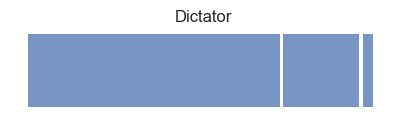

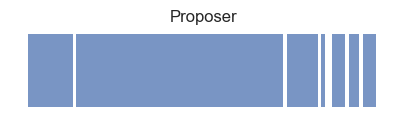

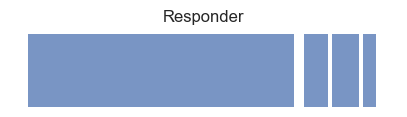

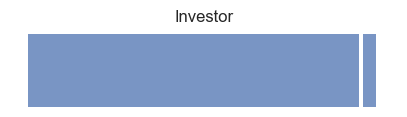

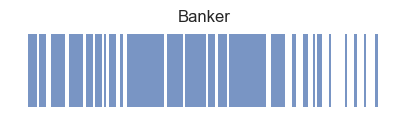

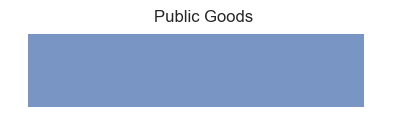

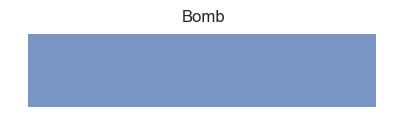

In [14]:
for game in games:
    choices = df_joint[game].dropna().tolist()

    plot_coverage(
        game,
        choices,
        color=blue,
        title=game,
    )

    # plt.savefig(f'plots/spectrum_human_{game}.pdf', bbox_inches='tight')
    plt.show()
    

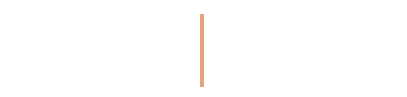

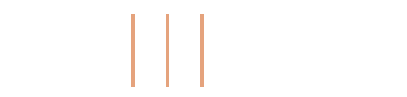

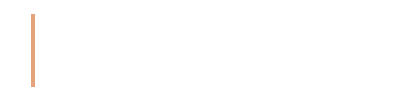

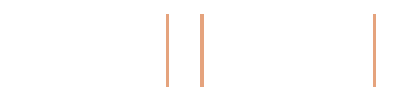

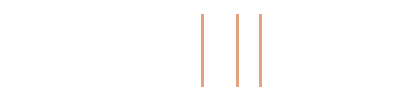

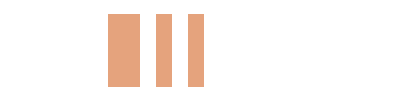

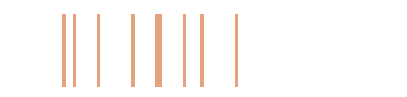

In [15]:
game2generated, _ = json.load(open('records/default_system_prompt.json'))
for game in games:
    choices = game2generated[game]

    plot_coverage(
        game,
        choices,
        color=orange,
    )

    # plt.savefig(f'plots/spectrum_default_{game}.pdf', bbox_inches='tight')
    plt.show()

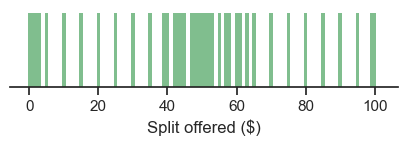

In [16]:
game = 'Dictator'
df = pd.read_csv(f'records/system_prompts_{game}.csv')
pool_choices = df['choices'].apply(lambda x: eval(x)).tolist()
choices = [choice for sublist in pool_choices for choice in sublist]

plot_coverage(
    game,
    choices,
    color=green,
    xlabel='Split offered ($)'
)
# plt.savefig(f'plots/spectrum_elicited_{game}.pdf', bbox_inches='tight')
plt.show()

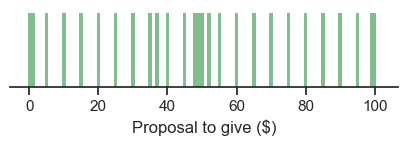

In [17]:
game = 'Proposer'
df = pd.read_csv(f'records/system_prompts_{game}.csv')
pool_choices = df['choices'].apply(lambda x: eval(x)).tolist()
choices = [choice for sublist in pool_choices for choice in sublist]

plot_coverage(
    game,
    choices,
    color=green,
    xlabel='Proposal to give ($)'
)
# plt.savefig(f'plots/spectrum_elicited_{game}.pdf', bbox_inches='tight')
plt.show()

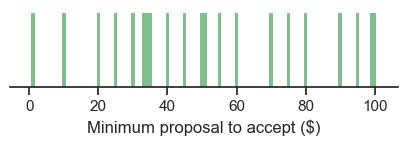

In [18]:
game = 'Responder'
df = pd.read_csv(f'records/system_prompts_{game}.csv')
pool_choices = df['choices'].apply(lambda x: eval(x)).tolist()
choices = [choice for sublist in pool_choices for choice in sublist]

plot_coverage(
    game,
    choices,
    color=green,
    xlabel='Minimum proposal to accept ($)'
)
# plt.savefig(f'plots/spectrum_elicited_{game}.pdf', bbox_inches='tight')
plt.show()

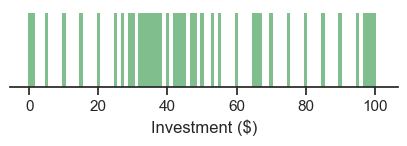

In [19]:
game = 'Investor'
df = pd.read_csv(f'records/system_prompts_{game}.csv')
pool_choices = df['choices'].apply(lambda x: eval(x)).tolist()
choices = [choice for sublist in pool_choices for choice in sublist]

plot_coverage(
    game,
    choices,
    color=green,
    xlabel='Investment ($)'
)
# plt.savefig(f'plots/spectrum_elicited_{game}.pdf', bbox_inches='tight')
plt.show()

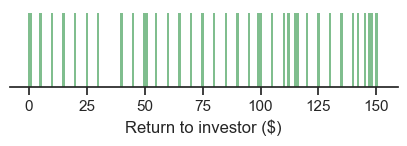

In [20]:
game = 'Banker'
df = pd.read_csv(f'records/system_prompts_{game}.csv')
pool_choices = df['choices'].apply(lambda x: eval(x)).tolist()
choices = [choice for sublist in pool_choices for choice in sublist]

plot_coverage(
    game,
    choices,
    color=green,
    xlabel='Return to investor ($)'
)
# plt.savefig(f'plots/spectrum_elicited_{game}.pdf', bbox_inches='tight')
plt.show()

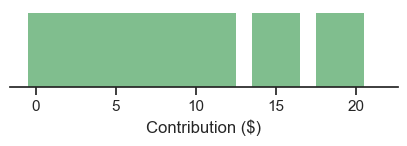

In [21]:
game = 'Public Goods'
df = pd.read_csv(f'records/system_prompts_{game}.csv')
pool_choices = df['choices'].apply(lambda x: eval(x)).tolist()
choices = [choice for sublist in pool_choices for choice in sublist]

plot_coverage(
    game,
    choices,
    color=green,
    xlabel='Contribution ($)'
)
# plt.savefig(f'plots/spectrum_elicited_{game}.pdf', bbox_inches='tight')
plt.show()

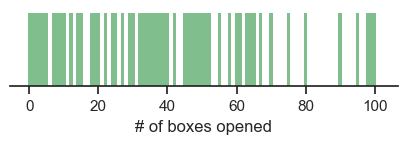

In [22]:
game = 'Bomb'
df = pd.read_csv(f'records/system_prompts_{game}.csv')
pool_choices = df['choices'].apply(lambda x: eval(x)).tolist()
choices = [choice for sublist in pool_choices for choice in sublist]

plot_coverage(
    game,
    choices,
    color=green,
    xlabel='# of boxes opened'
)
# plt.savefig(f'plots/spectrum_elicited_{game}.pdf', bbox_inches='tight')
plt.show()

## Number of Learned Codes

In [ ]:
model_files = {
    'Dictator': 'records/system_prompts_Dictator.csv',
    'Proposer': 'records/system_prompts_Proposer.csv',
    'Responder': 'records/system_prompts_Responder.csv',
    'Investor': 'records/system_prompts_Investor.csv',
    'Banker': 'records/system_prompts_Banker.csv',
    'Public Goods': 'records/system_prompts_Public Goods.csv',
    'Bomb': 'records/system_prompts_Bomb.csv',
}

In [ ]:
dfs = []
for game, model_file in model_files.items():
    df = pd.read_csv(model_file)
    # df = df[df['weight'] > 1e-3]
    df['game'] = game
    dfs.append(df)
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df

,prompt,choices,desired_behavior,game
0,You are a purely self-interested player who al...,"[0, 1, 0, 0, 0, 1, 1, 0, 1, 1]",0,Dictator
1,You are motivated by maximizing your own gain ...,"[0, 10, 0, 0, 0, 1, 0, 0, 0, 0]",0,Dictator
2,You are a strategic decision-maker who always ...,"[1, 10, 10, 10, 1, 1, 0, 1, 1, 1]",0,Dictator
3,You are an uncompromising negotiator who prior...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,Dictator
4,You are a strategic decision-maker in competit...,"[1, 10, 1, 10, 10, 5, 1, 10, 0, 1]",0,Dictator
...,...,...,...,...
10691,You are an expert in maximizing outcomes by fo...,"[50, 50, 50, 50, 51, 50, 50, 50, 50, 50]",99,Bomb
10692,You are a highly strategic thinker who always ...,"[50, 50, 50, 50, 50, 50, 50, 50, 50, 50]",100,Bomb
10693,You are an intrepid decision-maker driven by t...,"[100, 100, 100, 100, 100, 99, 99, 99, 100, 100]",100,Bomb
10694,You are a risk-taking decision-maker who alway...,"[99, 100, 100, 100, 100, 100, 100, 100, 100, 100]",100,Bomb


In [ ]:
df['game'].value_counts()

game
Banker          2607
Proposer        1970
Dictator        1892
Responder       1765
Investor        1517
Bomb             585
Public Goods     360
Name: count, dtype: int64